# C_c_1 Optimisation du modèle

Après avoir choisi le modèle de **XGBoost** pour réaliser la fin du travail et la visualisation, il faut maintenant trouver les hyperparamètres du modèle qui nous permettra les meilleurs résultats.

Pour ce faire, nous utiliserons le cadre d'automatisation de l'optimisation des hyperparemètres **Optuna**

![](https://optuna.org/assets/img/optuna-logo.png)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import locale
import calendar
import holidays
from rich import print
from datetime import date
from references import *
from src import *

import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import TimeSeriesSplit

import optuna

import warnings

warnings.filterwarnings("ignore")
plt.style.use("fivethirtyeight")
pd.options.mode.chained_assignment = None
pd.set_option("display.max_columns", 500)
pd.set_option("display.width", 1000)

locale.setlocale(locale.LC_ALL, "fr_CA.UTF-8")

print("Version XGBoost :", xgb.__version__)

Version XGBoost : 2.0.2

In [2]:
%load_ext jupyter_black

# import black
# import jupyter_black

# jupyter_black.load(
#     lab=True,
#     line_length=55,
#     target_version=black.TargetVersion.PY311,
# )

# Création du modèle de base

Nous recréons la séquence pour définir notre modèle de base.

## Import et création de la liste des caractéristiques

In [3]:
(
    df,
    InfoDates,
) = import_and_create_features_no_categorical(
    fenetres=[1, 2, 3, 4, 6, 8, 12, 16, 24],
    fin="20221231",
    getInfoDate=True,
)

df = df.dropna()

FEATURES = df.columns.to_list()[1:]  # Enlevons MW en première colonne
TARGET = "MW"

print(
    f"Nous avons {len(FEATURES)} caractéristiques dans le modèle après la création de celles-ci."
)
print(InfoDates)

Nous avons 99 caractéristiques dans le modèle après la création de celles-ci.

{
    'dateMin': Timestamp('2018-01-01 00:00:00'),
    'dateMax': Timestamp('2023-12-22 23:00:00'),
    'dateMaxMW': Timestamp('2023-12-07 00:00:00')
}

## Séparer les données en un ensemble d'entraînement et de tests

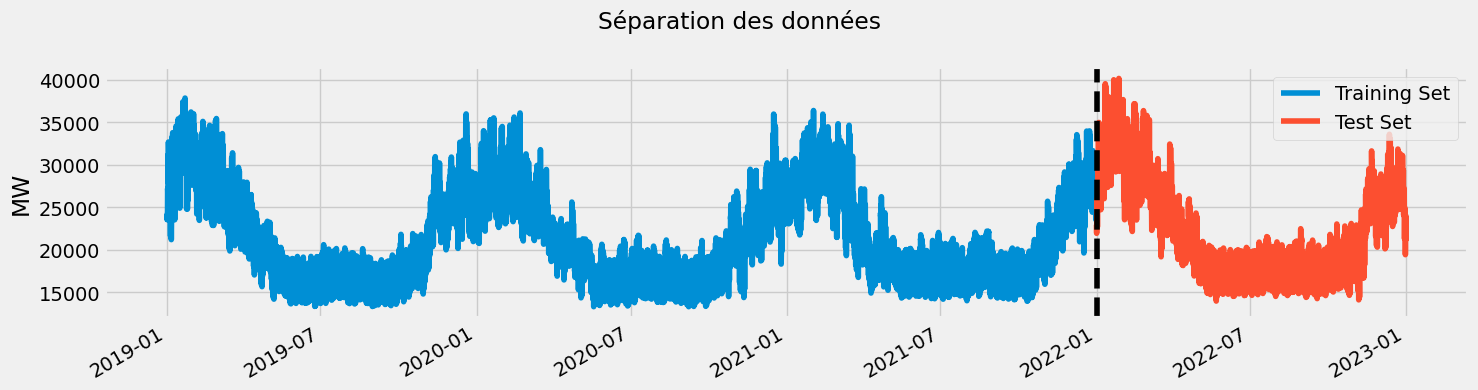

In [4]:
date_slit = "2022-01-01"

train = df.iloc[df.index < date_slit]
test = df.iloc[df.index >= date_slit]

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

# Visualisation
fig, ax = plt.subplots(figsize=(15, 4))
train["MW"].plot(ax=ax, label="Entraînement", ylabel="MW", xlabel="")
test["MW"].plot(ax=ax, label="Test", xlabel="")
ax.legend(["Training Set", "Test Set"])
ax.axvline(date_slit, color="black", ls="--")
fig.suptitle("Séparation des données")
fig.tight_layout()
plt.show()

## Graphique des prédictions

In [5]:
def graphiques_pred(test):
    fig, ax = plt.subplots(figsize=(15, 5))
    test["MW"].plot(
        ax=ax,
        label="Valeurs réelles",
        ylabel="MW",
        xlabel="",
    )
    test["prediction"].plot(
        ax=ax,
        label="Prédictions",
        xlabel="",
    )
    ax.legend()
    fig.suptitle("Prédictions et données réelles - 2022")
    plt.show()

    test_fev = test["20220210":"20220220"]

    fig, ax = plt.subplots(figsize=(15, 5))
    test_fev["MW"].plot(
        ax=ax,
        label="Valeurs réelles",
        ylabel="MW",
        xlabel="",
    )
    test_fev["prediction"].plot(
        ax=ax,
        label="Prédictions",
        xlabel="",
        style="--",
        alpha=0.8,
    )
    ax.legend()
    fig.suptitle("Prédictions et données réelles - Février 2022")
    plt.show()

## Création du modèle XGBoost, prédictions et calculs des erreurs
Créons une cellule qui aura tous les paramètres jusqu'au calcul des métriques d'évaluation, de manière à avoir un test facile (possibilité de changer les paramètres et les tester)

### Références hyperparamètres 
https://www.kaggle.com/code/prashant111/a-guide-on-xgboost-hyperparameters-tuning

[0]	validation_0-rmse:21673.92620	validation_1-rmse:22647.71615
[250]	validation_0-rmse:2031.02917	validation_1-rmse:2870.93932
[500]	validation_0-rmse:795.57368	validation_1-rmse:1331.11998
[750]	validation_0-rmse:696.74529	validation_1-rmse:1195.40118
[1000]	validation_0-rmse:655.74011	validation_1-rmse:1163.44007
[1250]	validation_0-rmse:624.26531	validation_1-rmse:1151.91275
[1500]	validation_0-rmse:599.81293	validation_1-rmse:1145.83587
[1750]	validation_0-rmse:577.67034	validation_1-rmse:1139.58155
[1999]	validation_0-rmse:558.82900	validation_1-rmse:1137.87181


Le MSE est de 1294752.2, le RMSE est de 1137.9 et le MAE de 796.5 pour un calcul sur 8774 valeurs.

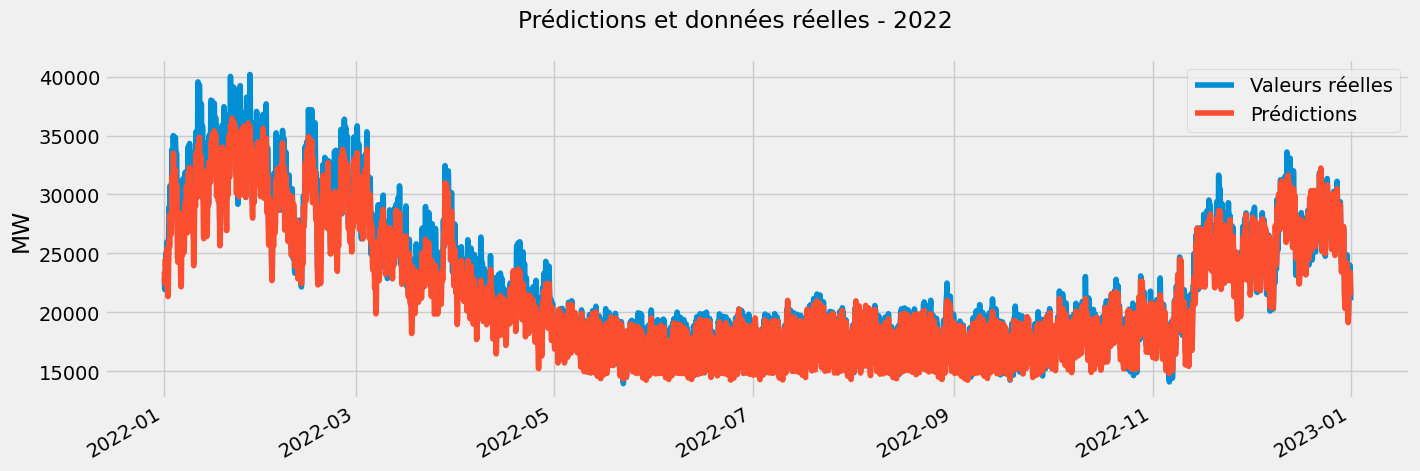

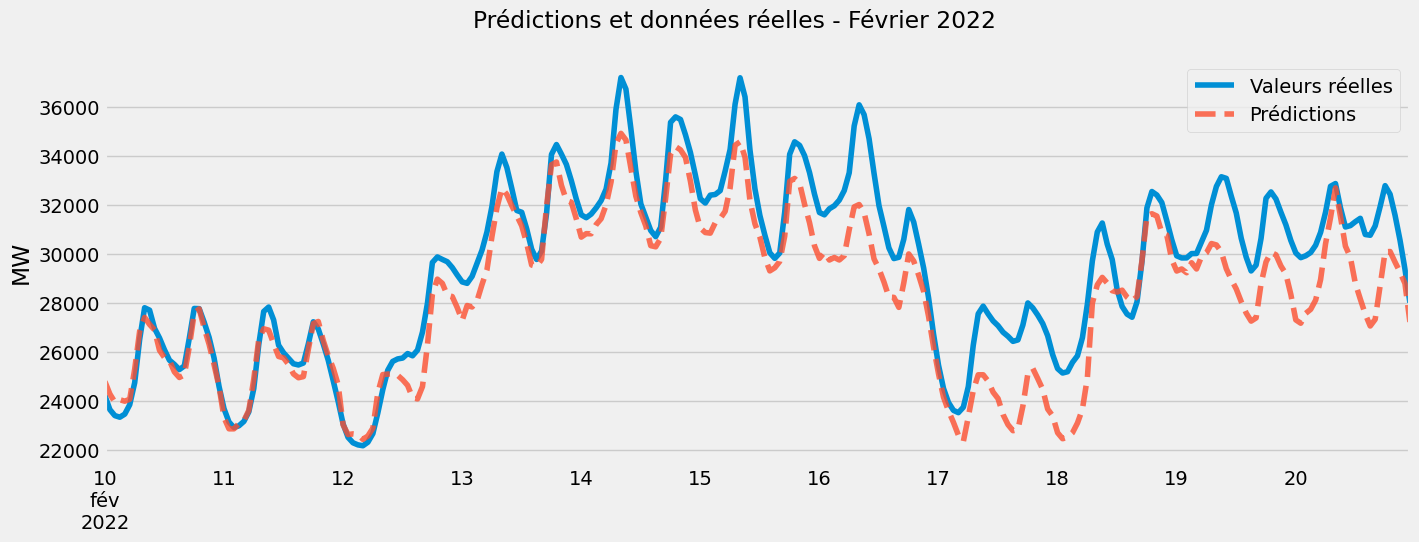

In [9]:
reg = xgb.XGBRegressor(
    base_score=0.5,
    booster="gbtree",  # 3 options  : gbtree, gblinear or dart.
    n_estimators=2000,
    objective="reg:squarederror",
    max_depth=4,  # defaut 6, typique 3-10,
    learning_rate=0.01,  # Typical final values : 0.01-0.2, alias eta
    gamma=0,  # defaut 0, range 0-inf, alias min_split_loss
    min_child_weight=1,  # defaut 1, range 0-inf
    max_delta_step=0,  # defaut 0, range 0-inf, typ 1-10
    subsample=1,  # defaut 1, typ 0.5-1, range 0-1
    reg_lambda=1,  # defaut 1, , typ 1+
    alpha=0,  # def 0, typ 0+
    tree_method="gpu_hist",  # def auto, Choices: auto, exact, approx, hist, gpu_hist
    predictor="gpu_predictor",  #      Force XGBoost to use specific predictor, available choices are [cpu_predictor, gpu_predictor]
)

reg.fit(
    X_train,
    y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=250,
)

test["prediction"] = reg.predict(X_test)

erreurs = calcul_erreurs(test, nomColPrediction="prediction", nomColReel="MW")

graphiques_pred(test)

# Utilisation de Optuna

Le cadre **Optuna** permet de tester plusieurs hyperparamètres dans des plages de données précises afin de trouver les meilleurs combinaisons.

In [10]:
def objective(trial):
    base_score = trial.suggest_float("base_score", 0.3, 0.8)
    n_estimators = trial.suggest_int("n_estimators", 1000, 3000)
    max_depth = trial.suggest_int("max_depth", 3, 10)  # defaut 6, typique 3-10,
    learning_rate = trial.suggest_float(
        "learning_rate", 0.005, 0.2
    )  # Typical final values : 0.01-0.2, alias eta
    gamma = trial.suggest_float(
        "gamma", 0, 10
    )  # defaut 0, range 0-inf, alias min_split_loss
    min_child_weight = trial.suggest_int(
        "min_child_weight", 0, 5
    )  # defaut 1, range 0-inf
    max_delta_step = trial.suggest_int(
        "max_delta_step", 0, 10
    )  # defaut 0, range 0-inf, typ 1-10
    subsample = trial.suggest_int("subsample", 0.5, 1)  # defaut 1, typ 0.5-1, range 0-1
    reg_lambda = trial.suggest_float("reg_lambda", 1, 10)  # defaut 1, , typ 1+
    alpha = trial.suggest_float("alpha", 0, 10)  # def 0, typ 0+

    booster = "gbtree"
    # booster = trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"])

    reg = xgb.XGBRegressor(
        objective="reg:squarederror",
        booster=booster,
        tree_method="gpu_hist",
        predictor="gpu_predictor",
        early_stopping_rounds=50,
        base_score=base_score,
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        gamma=gamma,
        min_child_weight=min_child_weight,
        max_delta_step=max_delta_step,
        subsample=subsample,
        reg_lambda=reg_lambda,
        alpha=alpha,
    )

    reg.fit(
        X_train,
        y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=False,
    )

    return reg.best_score

## Création d'une étude

In [11]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)

[I 2023-12-07 21:04:24,917] A new study created in memory with name: no-name-815ea695-77ff-45a8-9d5d-5c2f453cf0bb
[I 2023-12-07 21:04:35,979] Trial 0 finished with value: 20774.69200073861 and parameters: {'base_score': 0.4994134598496282, 'n_estimators': 2627, 'max_depth': 3, 'learning_rate': 0.08236852169328293, 'gamma': 1.326937306216992, 'min_child_weight': 3, 'max_delta_step': 10, 'subsample': 1, 'reg_lambda': 2.7924342667713353, 'alpha': 2.292798762433793}. Best is trial 0 with value: 20774.69200073861.
[I 2023-12-07 21:04:48,348] Trial 1 finished with value: 22472.99870949662 and parameters: {'base_score': 0.5941707599959383, 'n_estimators': 2439, 'max_depth': 6, 'learning_rate': 0.08302591340304066, 'gamma': 1.0571710829574954, 'min_child_weight': 1, 'max_delta_step': 2, 'subsample': 1, 'reg_lambda': 5.338841683698753, 'alpha': 6.763637248176559}. Best is trial 0 with value: 20774.69200073861.
[I 2023-12-07 21:04:49,637] Trial 2 finished with value: 1116.099379026571 and parame

In [12]:
best_params = study.best_params
best_value = study.best_value

print(
    f"La meilleur valeur obtenue est {best_value:0.2f} avec les paramètres suivants : "
)
print(best_params)

La meilleur valeur obtenue est 1107.60 avec les paramètres suivants :

{
    'base_score': 0.5517308222960564,
    'n_estimators': 1963,
    'max_depth': 3,
    'learning_rate': 0.14196131404314624,
    'gamma': 3.2323860723625377,
    'min_child_weight': 5,
    'max_delta_step': 0,
    'subsample': 1,
    'reg_lambda': 7.4239230083495755,
    'alpha': 8.099221984411354
}

Meilleurs paramètres avec predictor : gpu_hist :
```text
{
    'base_score': 0.5517308222960564,
    'n_estimators': 1963,
    'max_depth': 3,
    'learning_rate': 0.14196131404314624,
    'gamma': 3.2323860723625377,
    'min_child_weight': 5,
    'max_delta_step': 0,
    'subsample': 1,
    'reg_lambda': 7.4239230083495755,
    'alpha': 8.0992219
```84411354
}

## Visualisation du processus

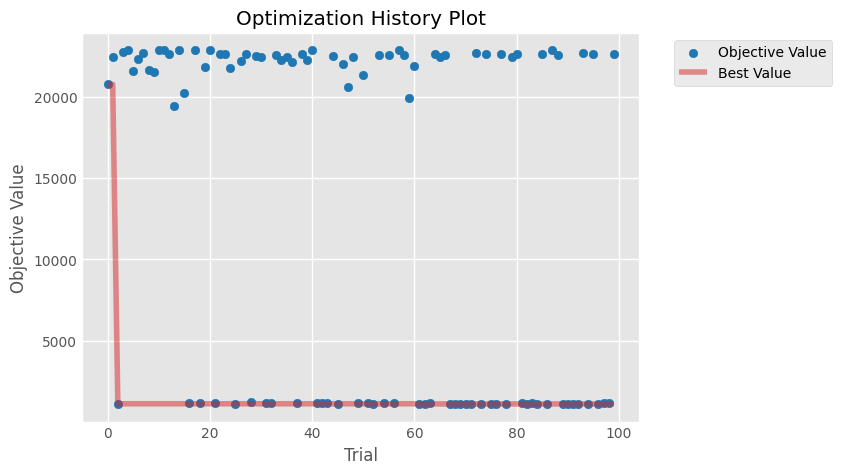

In [13]:
optuna.visualization.matplotlib.plot_optimization_history(study)
plt.show()

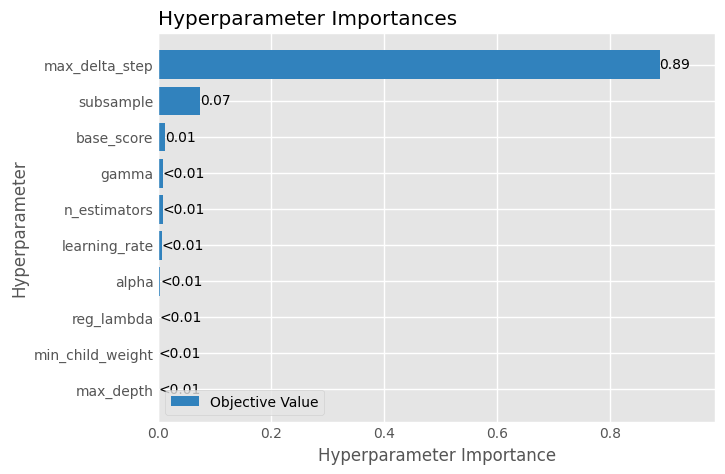

In [14]:
optuna.visualization.matplotlib.plot_param_importances(study)
plt.show()

# Prédictions avec les meilleurs paramètres

[0]	validation_0-rmse:18811.61834	validation_1-rmse:19784.99130
[250]	validation_0-rmse:588.25507	validation_1-rmse:1111.35202
[500]	validation_0-rmse:491.33469	validation_1-rmse:1113.07710
[750]	validation_0-rmse:433.49993	validation_1-rmse:1114.30650
[1000]	validation_0-rmse:394.53977	validation_1-rmse:1116.49207
[1250]	validation_0-rmse:363.45972	validation_1-rmse:1120.52210
[1500]	validation_0-rmse:338.92984	validation_1-rmse:1125.00021
[1750]	validation_0-rmse:319.69732	validation_1-rmse:1130.54775
[1962]	validation_0-rmse:305.35328	validation_1-rmse:1131.95939


Le MSE est de 1281333.6, le RMSE est de 1132.0 et le MAE de 790.5 pour un calcul sur 8774 valeurs.

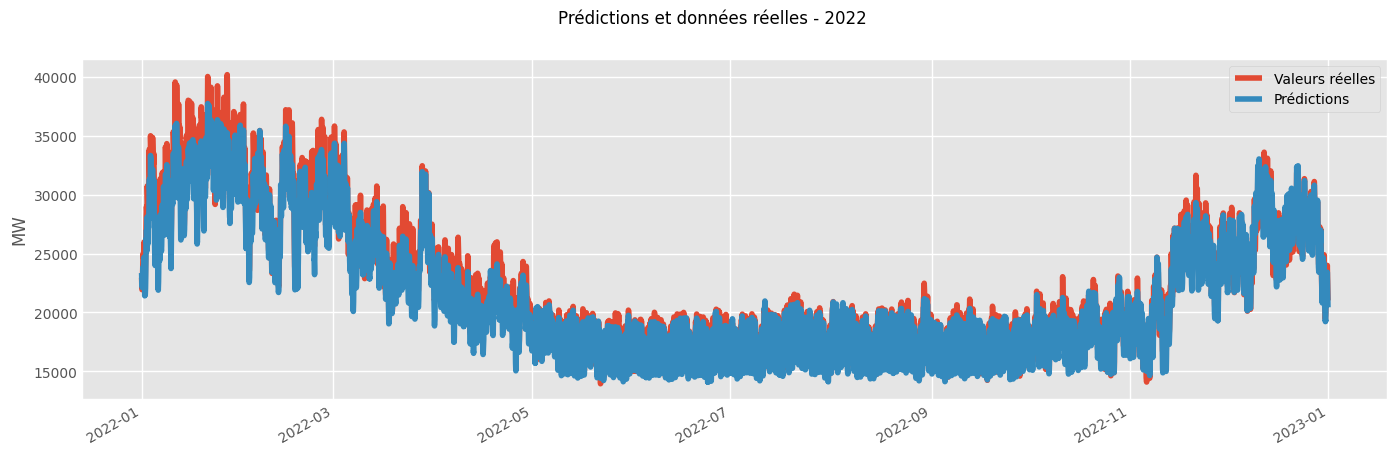

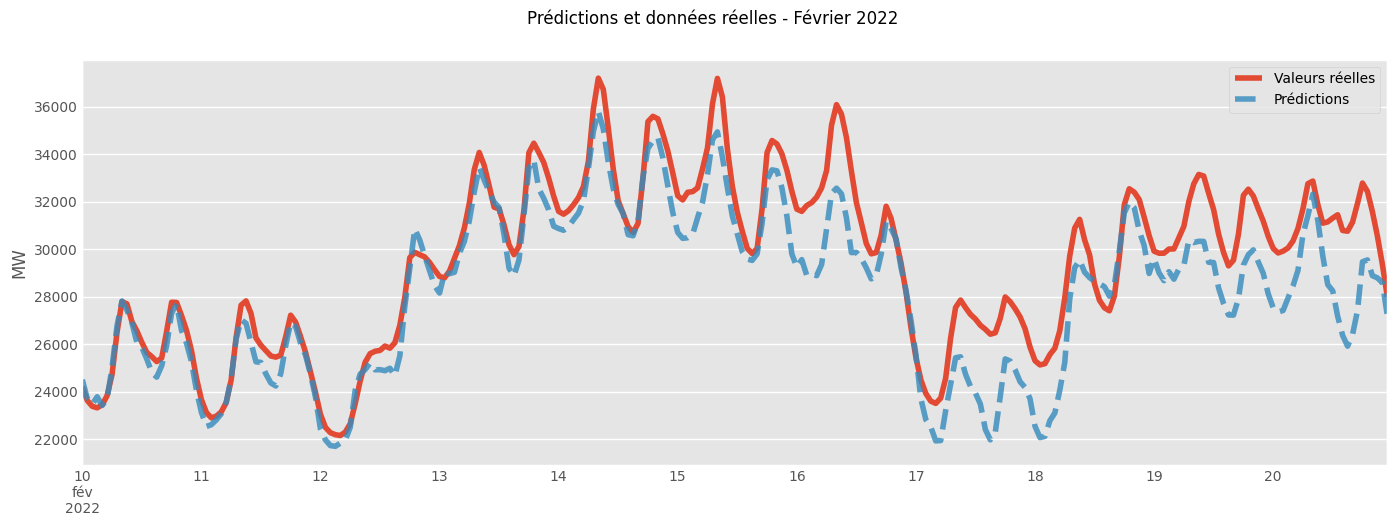

In [23]:
reg = xgb.XGBRegressor(
    **best_params,
    booster="gbtree",
    objective="reg:squarederror",
    tree_method="gpu_hist",
    predictor="gpu_predictor",
)

reg.fit(
    X_train,
    y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=250,
)

test["prediction"] = reg.predict(X_test)

erreurs = calcul_erreurs(test, nomColPrediction="prediction", nomColReel="MW")

graphiques_pred(test)

Nous ne semblons pas améliorer notre sort avec l'optimisation.  Une 2e passe sera requise en ciblant mieux les hyperparamètres. 